The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


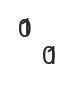

In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

In [49]:
def sum_fct(result, xd1, xd2):
    return result+xd1+xd2


def my_fct2(a, b, **kwargs):
    result = a+b
    output = sum_fct(result, **kwargs)
    return output

my_fct2(1,1, **{'xd1':1, 'xd2':1})

4

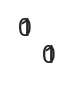

In [10]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

In [12]:
for f in tqdm(range(100)):
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

# load/filtering

In [15]:
from src.utils import flatten_level_columns

In [35]:
# Data downloaded from CEDAR on 13/06/2023 with the filtering
# Epitope structure: Linear
# Epitope source : Neoantigen
# Assay : TCell & MHC, positive and negative
# MHC Class I
# Cancer exposure : any
# Reference : Any

epitope_raw = flatten_level_columns(pd.read_csv('../data/new_filtering/230613_epitope.csv', header = [0,1]))
epitope = epitope_raw.drop(columns = filter(lambda x: 'iri' in x, epitope_raw.columns)).copy(deep=True)
assays_raw = flatten_level_columns(pd.read_csv('../data/new_filtering/230613_assays.csv', header = [0,1]))
assays = assays_raw.drop(columns = filter(lambda x: 'iri' in x, assays_raw.columns)).copy(deep=True)
antigens_raw = flatten_level_columns(pd.read_csv('../data/new_filtering/230613_antigen.csv', header = [0,1]))
antigens = antigens_raw.drop(columns = filter(lambda x: 'iri' in x, antigens_raw.columns)).copy(deep=True)

In [36]:
display(epitope.head())
display(assays.head())
display(antigens.head())

,epitope_object type,epitope_description,epitope_epitope modified residue(s),epitope_epitope modification(s),epitope_starting position,epitope_ending position,epitope_epitope synonyms,epitope_antigen name,epitope_parent protein,epitope_organism name,...,related object_epitope relationship,related object_object type,related object_description,related object_starting position,related object_ending position,related object_synonyms,related object_antigen name,related object_parent protein,related object_organism name,related object_parent organism
0,Linear peptide,ACDPHSGHFV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,ARDPHSGHFV,23.0,32.0,"Cell division protein kinase 4, PSK-J3, CDK4",Cyclin-dependent kinase 4,Cyclin-dependent kinase 4,Homo sapiens (human),Homo sapiens
1,Linear peptide,ATGFKQSSK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fusion neo-epitope,Multi-Chain Molecule,NaN,NaN,NaN,Abelson murine leukemia viral oncogene homolog...,Tyrosine-protein kinase ABL1,Tyrosine-protein kinase ABL1,Homo sapiens (human),Homo sapiens
2,Linear peptide,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,AAGIGILTV,27.0,35.0,"Antigen LB39-AA, Antigen SK29-AA, Protein Mela...",Melanoma antigen recognized by T-cells 1,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),Homo sapiens
3,Linear peptide,GFKQSSKAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fusion neo-epitope,Multi-Chain Molecule,NaN,NaN,NaN,Abelson murine leukemia viral oncogene homolog...,Tyrosine-protein kinase ABL1,Tyrosine-protein kinase ABL1,Homo sapiens (human),Homo sapiens
4,Linear peptide,IMDQVPFSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,ITDQVPFSV,209.0,217.0,"ME20-M, Melanocyte protein Pmel 17, Melanocyte...",Melanocyte protein PMEL,Melanocyte protein PMEL,Homo sapiens (human),Homo sapiens


,reference_type,reference_pubmed id,reference_authors,reference_journal,reference_date,reference_title,reference_submission id,epitope_object type,epitope_description,epitope_starting position,...,assay antigen_antigen epitope relation,assay antigen_antigen object type,assay antigen_antigen description,assay antigen_starting position,assay antigen_ending position,assay antigen_antigen source molecule name,assay antigen_protein parent name,assay antigen_antigen organism name,assay antigen_organism species name,assay comments_assay comments
0,Literature,15449035.0,Peter Hersey; Scott W Menzies; Brendon Coventr...,Cancer Immunol Immunother,2005,Phase I/II study of immunotherapy with T-cell ...,NaN,Linear peptide,IMDQVPFSV,NaN,...,Epitope,Linear peptide,IMDQVPFSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Literature,15534491.0,Hung T Khong; James C Yang; Suzanne L Topalian...,J Immunother,2004,Immunization of HLA-A*0201 and/or HLA-DPbeta1*...,NaN,Linear peptide,SLLMWITQV,NaN,...,Epitope,Linear peptide,SLLMWITQV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Literature,15534491.0,Hung T Khong; James C Yang; Suzanne L Topalian...,J Immunother,2004,Immunization of HLA-A*0201 and/or HLA-DPbeta1*...,NaN,Linear peptide,SLLMWITQV,NaN,...,Epitope,Linear peptide,SLLMWITQV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Literature,15837811.0,Ji-Li Chen; Guillaume Stewart-Jones; Giovanna ...,J Exp Med,2005,Structural and kinetic basis for heightened im...,NaN,Linear peptide,SLLMWITQV,NaN,...,Epitope,Linear peptide,SLLMWITQV,NaN,NaN,NaN,NaN,NaN,NaN,The crystal structure of the 1G4 TCR bound to ...
4,Literature,16600963.0,Steven M Dunn; Pierre J Rizkallah; Emma Baston...,Protein Sci,2006,Directed evolution of human T cell receptor CD...,NaN,Linear peptide,SLLMWITQV,NaN,...,Epitope,Linear peptide,SLLMWITQV,NaN,NaN,NaN,NaN,NaN,NaN,The epitope-specific mutant c49c50 TCR bound t...


,antigen_antigen name,antigen_antigen id,antigen_organism name,antigen_organism id,antigen_# epitopes,antigen_# assays,antigen_# references
0,Cytochrome b-c1 complex subunit 7,http://www.uniprot.org/uniprot/P14927,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,1,1,1
1,Bcl-2-like protein 13 (UniProt:Q9BXK5),http://www.uniprot.org/uniprot/Q9BXK5,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,1,1,1
2,E3 ubiquitin protein ligase,http://www.uniprot.org/uniprot/H3BP71,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,1,2,1
3,Unidentified protein,https://ontology.iedb.org/taxon-protein/32644,Unidentified,http://purl.obolibrary.org/obo/NCBITaxon_32644,11,18,1
4,Receptor protein-tyrosine kinase (UniProt:Q504U8),http://www.uniprot.org/uniprot/Q504U8,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,4,8,1


In [141]:
assays.head(2)

,reference_type,reference_pubmed id,reference_authors,reference_journal,reference_date,reference_title,reference_submission id,epitope_object type,epitope_description,epitope_starting position,epitope_ending position,epitope_antigen name,epitope_parent protein,epitope_organism name,epitope_parent species,epitope_epitope comments,related object_epitope relationship,related object_object type,related object_description,related object_starting position,related object_ending position,related object_synonyms,related object_antigen name,related object_parent protein,related object_organism name,...,assay_number of subjects tested,assay_number of subjects responded,assay_response frequency,effector cells_cell tissue type,effector cells_cell type,effector cells_cell culture conditions,tcr_assayed tcr molecule name,tcr_pdb id,antigen presenting cells_cell tissue type,antigen presenting cells_cell type,antigen presenting cells_cell culture conditions,mhc_allele name,mhc_class,mhc_allele evidence code,assay antigen_antigen epitope relation,assay antigen_antigen object type,assay antigen_antigen description,assay antigen_starting position,assay antigen_ending position,assay antigen_antigen source molecule name,assay antigen_protein parent name,assay antigen_antigen organism name,assay antigen_organism species name,assay comments_assay comments,len_epi
0,Literature,15449035.0,Peter Hersey; Scott W Menzies; Brendon Coventr...,Cancer Immunol Immunother,2005,Phase I/II study of immunotherapy with T-cell ...,NaN,Linear peptide,IMDQVPFSV,NaN,NaN,NaN,NaN,NaN,NaN,The gp100 analog used in this study was made m...,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,ITDQVPFSV,209.0,217.0,"ME20-M, Melanocyte protein Pmel 17, Melanocyte...",Melanocyte protein PMEL,Melanocyte protein PMEL,Homo sapiens (human),...,36.0,4.0,11.1,Blood,Lymphocyte,Short Term Restimulated,NaN,NaN,Lymphoid,T2 cells-Lymphoblast,Cell Line / Clone,HLA-A2,I,Not determined,Epitope,Linear peptide,IMDQVPFSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
1,Literature,15534491.0,Hung T Khong; James C Yang; Suzanne L Topalian...,J Immunother,2004,Immunization of HLA-A*0201 and/or HLA-DPbeta1*...,NaN,Linear peptide,SLLMWITQV,NaN,NaN,NaN,NaN,NaN,NaN,This epitope is an analogue of a naturally fou...,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,SLLMWITQC,157.0,165.0,Autoimmunogenic cancer/testis antigen NY-ESO-1...,Cancer/testis antigen 1,Cancer/testis antigen 1,Homo sapiens (human),...,19.0,NaN,NaN,Blood,T cell,Short Term Restimulated,NaN,NaN,Lymphoid,T2 cells-Lymphoblast,Cell Line / Clone,HLA-A*02:01,I,Not determined,Epitope,Linear peptide,SLLMWITQV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


## request stuff

In [180]:
import requests
from urllib import request as url_req
import requests
from bs4 import BeautifulSoup as BS

url = "https://www.iedb.org/details_v3.php?type=reference&id=1040606"


def get_content(url):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful (status code 200 indicates success)
    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")
        title = soup.title.string
        # Extract the resultData dictionary
        script_tag = soup.find("script", text=re.compile("var resultData ="))
        result_data = re.search(r"var resultData = ({.*?});", script_tag.string).group(1)
        result_data_dict = json.loads(result_data)
        # Print the extracted text content
        print(title, '\n\n', result_data)
        return title, result_data
    else:
        print("Error:", response.status_code)
        return None, None

In [181]:
from urllib import request
import re, json
url = 'https://www.iedb.org/details_v3.php?type=reference&id=1040606'
title, results = get_content(url)


Epitopes described in Immunogenicity and therapeutic targeting of a public neoantigen derived from mutated PIK3CA. - Immune Epitope Database (IEDB) 
 {"reference_id":{"label":"Reference ID","value":"1040606","identifier":"IEDB_reference:1040606"},"reference_type":{"label":"Reference Type","value":"Literature","identifier":"IEDB_Reference:1040606"},"reference_abstract":{"label":"Abstract","value":"Public neoantigens (NeoAgs) represent an elite class of shared cancer-specific epitopes derived from recurrently mutated driver genes. Here we describe a high-throughput platform combining single-cell transcriptomic and T cell receptor (TCR) sequencing to establish whether mutant PIK3CA, among the most frequently genomically altered driver oncogenes, generates an immunogenic public NeoAg. Using this strategy, we developed a panel of TCRs that recognize an endogenously processed neopeptide encompassing a common PIK3CA hotspot mutation restricted by the prevalent human leukocyte antigen (HLA)-A*

# Filtering assays

## explo

In [103]:
assays.columns

Index(['reference_type', 'reference_pubmed id', 'reference_authors',
       'reference_journal', 'reference_date', 'reference_title',
       'reference_submission id', 'epitope_object type', 'epitope_description',
       'epitope_starting position', 'epitope_ending position',
       'epitope_antigen name', 'epitope_parent protein',
       'epitope_organism name', 'epitope_parent species',
       'epitope_epitope comments', 'related object_epitope relationship',
       'related object_object type', 'related object_description',
       'related object_starting position', 'related object_ending position',
       'related object_synonyms', 'related object_antigen name',
       'related object_parent protein', 'related object_organism name',
       'related object_parent organism', 'host_name', 'host_geolocation',
       'host_mhc types present', '1st in vivo process_process type',
       '1st in vivo process_disease state',
       '1st in vivo process_disease stage',
       '1st in vivo pr

In [210]:
assays_f= assays.copy()
assays_f.query(lenmhc_query).groupby(['epitope_description','mhc_allele name']).agg(count=('len_epi','count')).query('count>=4')

,,count
epitope_description,mhc_allele name,
AALPILFQV,HLA-A*02:01,4
AIDAALTFV,HLA-A*02:01,9
AIKTSPKANK,HLA-A*30:01,4
ALDPHSGHFV,HLA-A*02:01,4
ALHGGWTTK,HLA-A*03:01,42
...,...,...
VVVGADGVGK,HLA-A*11:01,38
VVVPCEPPEV,HLA-A*02:01,5
VYFFLPDHL,HLA-A*24:02,5


In [221]:
assays_raw.query('epitope_description == "ALDPHSGHFV" or epitope_description == "AALPILFQV" or epitope_description=="AIKTSPKANK"')['reference_reference iri'].unique()

array(['http://www.iedb.org/reference/1030015',
       'http://www.iedb.org/reference/1039333',
       'http://www.iedb.org/reference/1039860',
       'http://www.iedb.org/reference/1040678',
       'http://www.iedb.org/reference/1041068'], dtype=object)

In [217]:
# Initial filter (len in [8,12], full mhc reso, 2 or fewer assays
assays['len_epi'] = assays['epitope_description'].apply(len)
lenmhc_query='len_epi>=8 and len_epi<=12 and `mhc_allele name`.str.contains("\*")'
assays_f= assays.copy()
assays_f= assays_f.query(lenmhc_query)
epis_to_keep = assays_f.groupby(['epitope_description','mhc_allele name']).agg(count=('len_epi','count')).query('count<=2').index
assays_f = assays_f.set_index(['epitope_description', 'mhc_allele name']).loc[epis_to_keep].copy().reset_index()

,epitope_description,mhc_allele name,reference_type,reference_pubmed id,reference_authors,reference_journal,reference_date,reference_title,reference_submission id,epitope_object type,epitope_starting position,epitope_ending position,epitope_antigen name,epitope_parent protein,epitope_organism name,epitope_parent species,epitope_epitope comments,related object_epitope relationship,related object_object type,related object_description,related object_starting position,related object_ending position,related object_synonyms,related object_antigen name,related object_parent protein,...,assay_quantitative measurement,assay_number of subjects tested,assay_number of subjects responded,assay_response frequency,effector cells_cell tissue type,effector cells_cell type,effector cells_cell culture conditions,tcr_assayed tcr molecule name,tcr_pdb id,antigen presenting cells_cell tissue type,antigen presenting cells_cell type,antigen presenting cells_cell culture conditions,mhc_class,mhc_allele evidence code,assay antigen_antigen epitope relation,assay antigen_antigen object type,assay antigen_antigen description,assay antigen_starting position,assay antigen_ending position,assay antigen_antigen source molecule name,assay antigen_protein parent name,assay antigen_antigen organism name,assay antigen_organism species name,assay comments_assay comments,len_epi
0,AAASATLAL,HLA-C*08:01,Literature,36651232.0,Song Gao; Jiaqian Wang; Zhongzheng Zhu; Juemin...,Immunotherapy,2023,Effective personalized neoantigen vaccine plus...,NaN,Linear peptide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in-frame neo-epitope,Fragment of a Natural Sequence Molecule,AAASATLAS,45.0,53.0,SOX30,Transcription factor SOX-30,Transcription factor SOX-30,...,NaN,NaN,NaN,NaN,Blood,T cell CD8+,Short Term Restimulated,NaN,NaN,Blood,Dendritic cell,Direct Ex Vivo,I,MHC binding prediction,Epitope,Linear peptide,AAASATLAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
1,AAHFTVLLY,HLA-A*11:01,Literature,31511069.0,Michael Fehlings; Suchit Jhunjhunwala; Marcin ...,J Immunother Cancer,2019,Late-differentiated effector neoantigen-specif...,NaN,Linear peptide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,AAHFTALLY,1949.0,1957.0,NaN,ATM gene,Serine-protein kinase ATM,...,NaN,NaN,NaN,NaN,Blood,T cell CD8+,Direct Ex Vivo,NaN,NaN,NaN,NaN,NaN,I,MHC binding prediction,Epitope,Linear peptide,AAHFTVLLY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,AAIAASRSV,HLA-C*12:03,Literature,30556813.0,Brendan Bulik-Sullivan; Jennifer Busby; Christ...,Nat Biotechnol,2018,Deep learning using tumor HLA peptide mass spe...,NaN,Linear peptide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,AAIAASRSA,6.0,14.0,NaN,Chromosome 1 open reading frame 198 [Homo sapi...,Uncharacterized protein C1orf198,...,NaN,NaN,NaN,NaN,Blood,PBMC,Short Term Restimulated,NaN,NaN,Blood,PBMC,Direct Ex Vivo,I,MHC binding prediction,Epitope,Linear peptide,AAIAASRSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
3,AAKAALEDF,HLA-C*16:01,Literature,30556813.0,Brendan Bulik-Sullivan; Jennifer Busby; Christ...,Nat Biotechnol,2018,Deep learning using tumor HLA peptide mass spe...,NaN,Linear peptide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,AAKAALEEF,376.0,384.0,NaN,"SWI/SNF related, matrix associated, actin depe...",SWI/SNF complex subunit SMARCC1,...,NaN,NaN,NaN,NaN,Blood,PBMC,Short Term Restimulated,NaN,NaN,Blood,PBMC,Direct Ex Vivo,I,MHC binding prediction,Epitope,Linear peptide,AAKAALEDF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
4,AAMHGRKIM,HLA-B*07:02,Literature,31511069.0,Michael Fehlings; Suchit Jhunjhunwala; Marcin ...,J Immunother Cancer,2019,Late-differentiated effector neoantigen-specif...,NaN,Linear peptide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unspecified neo-epitope,Fragment of a Natural Sequence Molecule,AAMNGRKIM,66.0,74.0,p40-TIA-1 (containing p15-TIA-1); T-cell-restr...,nucleolysin TIA-1 isoform p40 isoform 15 [Homo...,Nucleolysin TIA-1 isoform p40,...,NaN,NaN,NaN,NaN,Blood

In [219]:
assays_raw['len_epi'] = assays_raw['epitope_description'].apply(len)
xd=assays_raw.query(lenmhc_query).groupby(['epitope_description', 'mhc_allele name', 'reference_pubmed id']).agg(count=('len_epi', 'count'))
epis_todrop = xd.reset_index().groupby(['epitope_description', 'mhc_allele name']).count().query('count>1').reset_index('mhc_allele name').index
assays_filt = assays.copy().query(lenmhc_query).query('epitope_description not in @epis_todrop')
assays_filt.groupby(['epitope_description','mhc_allele name']).agg(count=('len_epi','count')).query('count>3 and count<10')

,,count
epitope_description,mhc_allele name,
AALPILFQV,HLA-A*02:01,4
AIKTSPKANK,HLA-A*30:01,4
ALDPHSGHFV,HLA-A*02:01,4
ALLPGLPAA,HLA-A*02:01,6
ALPQHLIRV,HLA-A*02:01,4
ASNASSAAK,HLA-A*11:01,9
AVCPWTWLR,HLA-A*11:01,4
EVISCKLIKR,HLA-A*68:01,4
FIASNGVKLV,HLA-A*02:01,8


In [227]:
assays_raw['len_epi'] = assays_raw['epitope_description'].apply(len)
assays_raw.query(lenmhc_query).groupby(['epitope_description', 'mhc_allele name', 'reference_reference iri']).agg(count=('len_epi', 'count')).query('count<=3').sort_values('count', ascending=False)

,,,count
epitope_description,mhc_allele name,reference_reference iri,
KLYEEPLLK,HLA-A*03:01,http://www.iedb.org/reference/1041065,3
SEHSPVSEPV,HLA-B*49:01,http://www.iedb.org/reference/1041069,3
VYRPLHYPLL,HLA-C*07:02,http://www.iedb.org/reference/1037146,3
FWYTHNLIF,HLA-C*14:03,http://www.iedb.org/reference/1032714,3
SLLRSLENV,HLA-A*02:01,http://www.iedb.org/reference/1035929,3
...,...,...,...
KIDIERILSV,HLA-A*02:01,http://www.iedb.org/reference/1037775,1
KICMQCPLSK,HLA-A*11:01,http://www.iedb.org/reference/1031919,1
KHMWLKPVSW,HLA-A*24:02,http://www.iedb.org/reference/1041391,1


In [113]:
# Second filter, taking only datapoints with wildtype description
assays_f.dropna(subset=['related object_description'], inplace=True)
assays_f['wt_true'] = assays_f['related object_description'].apply(lambda x: x==x.upper())
assays_f = assays_f.query('wt_true')
epirelcols = list(filter(lambda x: x=='mhc_allele name' or 'epitope' in x or 'related' in x, assays_f.columns))

In [124]:
qr = assays_f.query('`related object_epitope relationship`!="unspecified neo-epitope"')[epirelcols]
to_drop = qr.columns[qr.isna().all(axis=0)]
qr.drop(columns=to_drop)

,epitope_description,mhc_allele name,epitope_object type,related object_epitope relationship,related object_object type,related object_description,related object_starting position,related object_ending position,related object_synonyms,related object_antigen name,related object_parent protein,related object_organism name,related object_parent organism,in vitro process_immunogen epitope relation,assay antigen_antigen epitope relation
0,AAASATLAL,HLA-C*08:01,Linear peptide,in-frame neo-epitope,Fragment of a Natural Sequence Molecule,AAASATLAS,45.0,53.0,SOX30,Transcription factor SOX-30,Transcription factor SOX-30,Homo sapiens (human),Homo sapiens,Epitope,Epitope
187,ATSPASASK,HLA-A*11:01,Linear peptide,in-frame neo-epitope,Fragment of a Natural Sequence Molecule,ATSPASASFK,93.0,102.0,"Early response protein NAK1, Nuclear hormone r...",Nuclear receptor subfamily 4 group A member 1,Nuclear receptor subfamily 4 group A member 1,Homo sapiens (human),Homo sapiens,Epitope,Epitope
1666,MLICCCCTL,HLA-A*02:10,Linear peptide,in-frame neo-epitope,Fragment of a Natural Sequence Molecule,VLICCCCTL,157.0,165.0,Electroneutral potassium-chloride cotransporte...,Solute carrier family 12 member 4,Solute carrier family 12 member 4,Homo sapiens (human),Homo sapiens,Epitope,Epitope
2208,SEHGFGPSL,HLA-B*40:01,Linear peptide,frameshift neo-epitope,Fragment of a Natural Sequence Molecule,SEHGFGPIT,184.0,192.0,peptide met (O) reductase; mitochondrial pepti...,mitochondrial peptide methionine sulfoxide red...,Mitochondrial peptide methionine sulfoxide red...,Homo sapiens (human),Homo sapiens,Epitope,Epitope
2210,SEIISFKSL,HLA-B*40:01,Linear peptide,in-frame neo-epitope,Fragment of a Natural Sequence Molecule,SEIISFKSM,51.0,59.0,FEZ1,Fasciculation and elongation protein zeta-1,Fasciculation and elongation protein zeta-1,Homo sapiens (human),Homo sapiens,Epitope,Epitope
2647,VEWLGRCIL,HLA-B*40:01,Linear peptide,in-frame neo-epitope,Fragment of a Natural Sequence Molecule,DEWLGRCIL,276.0,284.0,NaN,Chondroitin polymerizing factor [Homo sapiens],Chondroitin sulfate synthase 2,Homo sapiens (human),Homo sapiens,Epitope,Epitope


## Take only pep appearing in a SINGLE publication with fewer/eq to 3 assays

In [287]:
# Get agg label etc
def get_dupe_unique_df(df):
    """
    From the source df, get the unique (keeping first) AND the duplicates df, and the common indices
    """
    dup_df = df.loc[df.duplicated(subset='epitope_description', keep=False)].sort_values('epitope_description')
    unique_df = df.drop_duplicates(subset='epitope_description', keep ='first')
    common_indices = dup_df.index.join(unique_df.index, how = 'inner')
    return unique_df, dup_df, common_indices

def get_agg_label(dup_df):
    dup_df['label'] = dup_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    agg_label = dup_df.groupby('epitope_description').agg({'label':"max"})
    gb = dup_df.groupby(['epitope_description', 'label']).agg({'label':"count"}).rename(columns={'label':'count'})
    return agg_label

def get_agg(dup_df):
    dup_df['label'] = dup_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    
    gb = dup_df.groupby(['epitope_description', 'label']).agg({'label':"count"}).rename(columns={'label':'count'})#.reset_index()
    gb['percentage_pos'] = gb/gb.groupby(['epitope_description']).agg({'count':"sum"})
    agg = gb.reset_index().groupby(['epitope_description']).agg({'label':'max', 'percentage_pos':"max"}).rename(columns={'label':'agg_label'})
    agg.loc[agg['agg_label']==0, 'percentage_pos']=0
    agg['total'] = gb.reset_index().groupby('epitope_description').agg({'count':"sum"})
    return agg

def assign_agg_metrics(unique_df, agg_df, common_indices):
    unique_df['agg_label'] = unique_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    unique_df['total_count'] = 1
    unique_df['percentage_pos'] = unique_df['agg_label']
    unique_df.loc[common_indices, 'agg_label'] = agg['agg_label'].values
    unique_df.loc[common_indices, 'total_count'] = agg['total'].values
    unique_df.loc[common_indices, 'percentage_pos'] = agg['percentage_pos'].values
    return unique_df


In [288]:
# Initial filter (len in [8,12], full mhc reso, 2 or fewer assays and wt annotation
assays['len_epi'] = assays['epitope_description'].apply(len)
lenmhc_query='len_epi>=8 and len_epi<=12 and `mhc_allele name`.str.contains("\*")'
assays_f = assays.copy()
assays_f = assays_f.query(lenmhc_query)
assays_f.dropna(subset=['related object_description'], inplace=True)
assays_f['wt_true'] = assays_f['related object_description'].apply(lambda x: x==x.upper())
assays_f = assays_f.query('wt_true')
# Filtering epitopes that appear in more than 1 paper
papers_filter = assays_f.groupby(['epitope_description', 'mhc_allele name', 'reference_pubmed id']).agg(count=('len_epi','count')).reset_index().groupby(['epitope_description', 'mhc_allele name']).agg(count=('reference_pubmed id', 'count')).query('count>1').reset_index('mhc_allele name').index
assays_f = assays_f.query('epitope_description not in @papers_filter')
# Filtering epitopes that appear in more than 3 assays
epis_to_keep = assays_f.groupby(['epitope_description','mhc_allele name']).agg(count=('len_epi','count')).query('count<=3').index
assays_f = assays_f.set_index(['epitope_description', 'mhc_allele name']).loc[epis_to_keep].copy().reset_index()
# Aggregate the labels using the rule : at least 1 positive = positive, else = negative

In [289]:
assays_filt = assays_f[['epitope_description', 'related object_description', 'mhc_allele name', 'assay_qualitative measure']]

unique_df, dup_df, common_indices = get_dupe_unique_df(assays_filt)
# Keep unique entries and re-assign labels
agg = get_agg(dup_df)
assays_filt = assign_agg_metrics(unique_df, agg, common_indices)\
                .drop(columns=['assay_qualitative measure'])\
                .sort_values(['epitope_description', 'mhc_allele name'])\
                .rename(columns={'epitope_description':'Peptide', 
                                 'related object_description':'wild_type',
                                 'mhc_allele name':'HLA'}).reset_index(drop=True)
assays_filt['HLA'] = assays_filt['HLA'].apply(lambda x: x.replace('*','').replace(':',''))
assays_filt

,Peptide,wild_type,HLA,agg_label,total_count,percentage_pos
0,AAASATLAL,AAASATLAS,HLA-C0801,1,1,1.0
1,AAHFTVLLY,AAHFTALLY,HLA-A1101,0,1,0.0
2,AAIAASRSV,AAIAASRSA,HLA-C1203,0,1,0.0
3,AAKAALEDF,AAKAALEEF,HLA-C1601,0,1,0.0
4,AAMHGRKIM,AAMNGRKIM,HLA-B0702,0,1,0.0
...,...,...,...,...,...,...
2451,YYNFEGDIALL,SYNFEGDIALL,HLA-A2402,0,2,0.0
2452,YYPGKKEPF,YYSGKKEPF,HLA-A2402,0,2,0.0
2453,YYSKNLNSF,YYSKNLNSS,HLA-A2402,1,1,1.0
2454,YYSKNLNSFF,YYSKNLNSSF,HLA-A2402,1,2,1.0


In [293]:
assays_filt['len_mut'] = assays_filt['Peptide'].apply(len)
assays_filt['len_wt'] = assays_filt['wild_type'].apply(len)
# Don't care about point mutation for now but Pept shoul
assays_filt = assays_filt.query('len_wt>=8 and len_wt<=12')

## making folds / sending df to prep

In [295]:
assays_filt[['Peptide','wild_type','HLA','agg_label']].to_csv('../../netmhcpan/score_pipeline/data/230613_cedar_filtered.txt', index=False,header=False)
assays_filt['Peptide'].to_csv('../../kern_dist/230613_cedar_filtered.pep', index=False,header=False)

# Sending to computerome and running my pipeline scripts

In [307]:
assays_filt

,Peptide,wild_type,HLA,agg_label,total_count,percentage_pos,len_mut,len_wt
0,AAASATLAL,AAASATLAS,HLA-C0801,1,1,1.0,9,9
1,AAHFTVLLY,AAHFTALLY,HLA-A1101,0,1,0.0,9,9
2,AAIAASRSV,AAIAASRSA,HLA-C1203,0,1,0.0,9,9
3,AAKAALEDF,AAKAALEEF,HLA-C1601,0,1,0.0,9,9
4,AAMHGRKIM,AAMNGRKIM,HLA-B0702,0,1,0.0,9,9
...,...,...,...,...,...,...,...,...
2451,YYNFEGDIALL,SYNFEGDIALL,HLA-A2402,0,2,0.0,11,11
2452,YYPGKKEPF,YYSGKKEPF,HLA-A2402,0,2,0.0,9,9
2453,YYSKNLNSF,YYSKNLNSS,HLA-A2402,1,1,1.0,9,9
2454,YYSKNLNSFF,YYSKNLNSSF,HLA-A2402,1,2,1.0,10,10


In [331]:
cedar_icore = pd.read_csv('../../netmhcpan/score_pipeline/output/230613_cedar_filtered.txt.txt', sep = ' ').drop(columns=['HLA']).rename(columns={'Peptide':'Peptide_mut'})
cedar_fullpep = pd.read_csv('../../netmhcpan/score_pipeline/output/230613_cedar_filtered_fullpep.txt', sep = ' ', header=None, names = ['start', 'HLA', 'Peptide','Core', 'x1','x2','x3','x4','x5', 'x6', 'trueHLA_EL_rank'])

,Peptide,wild_type,HLA,agg_label,total_count,percentage_pos,len_mut,len_wt,icore_start_pos,Peptide_mut,Core,Of,Gp,Gl,Ip,Il,icore_mut,EL_rank_mut,icore_wt_aligned,EL_rank_wt_aligned,icore_similarity_score,trueHLA_EL_rank
0,AAASATLAL,AAASATLAS,HLA-C0801,1,1,1.0,9,9,1,AAASATLAL,AAASATLAL,0,0,0,0,0,AAASATLAL,0.052,AAASATLAS,8.004,0.982822,0.052
1,AAHFTVLLY,AAHFTALLY,HLA-A1101,0,1,0.0,9,9,1,AAHFTVLLY,AAHFTVLLY,0,0,0,0,0,AAHFTVLLY,0.420,AAHFTALLY,0.588,0.951034,0.420
2,AAIAASRSV,AAIAASRSA,HLA-C1203,0,1,0.0,9,9,1,AAIAASRSV,AAIAASRSV,0,0,0,0,0,AAIAASRSV,0.059,AAIAASRSA,1.173,0.987735,0.059
3,AAKAALEDF,AAKAALEEF,HLA-C1601,0,1,0.0,9,9,1,AAKAALEDF,AAKAALEDF,0,0,0,0,0,AAKAALEDF,1.056,AAKAALEEF,0.160,0.972773,1.056
4,AAMHGRKIM,AAMNGRKIM,HLA-B0702,0,1,0.0,9,9,1,AAMHGRKIM,AAMHGRKIM,0,0,0,0,0,AAMHGRKIM,0.670,AAMNGRKIM,0.739,0.921524,0.670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,YYNFEGDIALL,SYNFEGDIALL,HLA-A2402,0,2,0.0,11,11,1,YYNFEGDIALL,YYNGDIALL,0,3,2,0,0,YYNFEGDIALL,0.625,SYNFEGDIALL,0.758,0.981957,0.625
2431,YYPGKKEPF,YYSGKKEPF,HLA-A2402,0,2,0.0,9,9,1,YYPGKKEPF,YYPGKKEPF,0,0,0,0,0,YYPGKKEPF,0.097,YYSGKKEPF,0.082,0.927951,0.097
2432,YYSKNLNSF,YYSKNLNSS,HLA-A2402,1,1,1.0,9,9,1,YYSKNLNSF,YYSKNLNSF,0,0,0,0,0,YYSKNLNSF,0.003,YYSKNLNSS,4.686,0.974386,0.003
2433,YYSKNLNSFF,YYSKNLNSSF,HLA-A2402,1,2,1.0,10,10,1,YYSKNLNSF,YYSKNLNSF,0,0,0,0,0,YYSKNLNSF,0.003,YYSKNLNSS,4.686,0.974386,0.031


In [334]:
from src.partition_tools import pipeline_stratified_kfold
cedar_fold = pd.merge(assays_filt.reset_index(drop=True), cedar_icore.reset_index(drop=True), left_index=True, right_index=True).merge(cedar_fullpep['trueHLA_EL_rank'], left_index=True,right_index=True)
cedar_fold = pipeline_stratified_kfold(hobohm_filename='../../kern_dist/out/230613_cedar_filtered.pep_0.9.out',
                          original_df=cedar_fold.reset_index(drop=True), k=10, elrank_col = 'EL_rank_mut', target_col='agg_label', pep_col='Peptide', hla_col='HLA')

start 2435
read hobohm 2060 375
strat kfold unique 2060 375
manually reassign identical 2060 375
manually reassign related 2060 375
concat 2435
merge 2435
drop duplicated 2435


In [335]:
cedar_fold.to_csv('../data/new_filtering/230613_cedar_fold_newfiltering.csv', index=False)

# Do the training thing here

In [13]:
cedar_fold = pd.read_csv('../data/new_filtering/230613_cedar_fold_newfiltering.csv')

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
import itertools
from functools import partial
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from datetime import datetime as dt
import os, sys
import copy
import tracemalloc
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Custom fct imports
from src.utils import pkl_load, pkl_dump
import argparse
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, AA_KEYS, get_aa_properties
from src.utils import mkdirs, convert_path, str2bool
from src.metrics import get_nested_feature_importance
from src.bootstrap import bootstrap_eval, get_pval_wrapper
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from copy import deepcopy

N_CORES = 8


def final_bootstrap_wrapper(preds_df, filename, input_type, cdt, ODIR,
                            n_rounds=10000, n_jobs=8):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df = bootstrap_eval(y_score=scores, y_true=targets, n_rounds=n_rounds,
                                     n_jobs=n_jobs, add_roc=False, reduced=True)
    bootstrapped_df['weight'] = cdt
    bootstrapped_df['input_type'] = input_type
    bootstrapped_df.to_csv(f'{ODIR}bootstrapped_df_{fn}.csv', index=False)
    return bootstrapped_df

In [36]:
train_dataset = cedar_fold.query('HLA in @HLAS')
ics_kl = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')
ODIR = '../output/230613_refiltered_cedar/'
RDIR = ODIR+'raw/'
BDIR = ODIR+'boot/'
os.makedirs(ODIR, exist_ok=True)
os.makedirs(RDIR, exist_ok=True)
os.makedirs(BDIR, exist_ok=True)

# DEFINING KWARGS
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'hla_col': 'HLA',
                   'add_aaprop': False,
                   'remove_pep': False,
                   'mut_col': [],
                   'standardize': True}

conditions_list = {'Inverted-Shannon': (True, 'Inverted-Shannon', ics_shannon, False),
                   'None': (False, 'None', None, False),
                   'Mask': (False, 'Mask', ics_shannon, True),
                   'Shannon': (False, 'Shannon', ics_shannon, False),
                   'Inverted-Mask': (True, 'Inverted-Mask', ics_shannon, True),
                   'KL': (False, 'KL', ics_kl, False),
                   'Inverted-KL': (True, 'Inverted-KL', ics_kl, False),
                   'KL-Mask':(False, 'KL-Mask', ics_kl, True),
                   'Inverted-KL-Mask':(True, 'Inverted-KL-Mask', ics_kl, True)}

for input_type, cdt in tqdm(list(product(['Peptide', 'icore_mut'], conditions_list.keys())), desc='cdt'):
    encoding_kwargs['rank_col'] = 'EL_rank_mut' if input_type =='icore_mut' else 'trueHLA_EL_rank'
    encoding_kwargs['seq_col'] = input_type
    invert, ic_name, ics_dict, mask = conditions_list[cdt]
    # megaloops for encoding-weighting
    encoding_kwargs['threshold']=0.201 if 'KL' in cdt else 0.236
    encoding_kwargs['encoding'] = 'onehot'
    encoding_kwargs['blosum_matrix'] = None
    # Doing only Inverted Shannon, Mask, None
    encoding_kwargs['invert'] = invert
    encoding_kwargs['mask'] = mask
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                               max_depth=8, ccp_alpha=9.945e-6)
    fn = f'{input_type}_{cdt}'
    # Training model and getting feature importances
    print('Training')
    trained_models, _, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                    ics_dict=ics_dict,
                                                    encoding_kwargs=encoding_kwargs, n_jobs=8)
    _, kcv_preds = evaluate_trained_models_sklearn(train_dataset, trained_models, ics_dict, train_dataset, encoding_kwargs, concatenated=False, only_concat=False, kcv_eval=True, n_jobs=8)
    p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
    kcv_preds.to_csv(f'{RDIR}preds_{fn}.csv', index=False)
    _ = final_bootstrap_wrapper(kcv_preds, fn, input_type, cdt, ODIR, n_rounds=10000, n_jobs=8)
        

NameError: name 'cedar_fold' is not defined

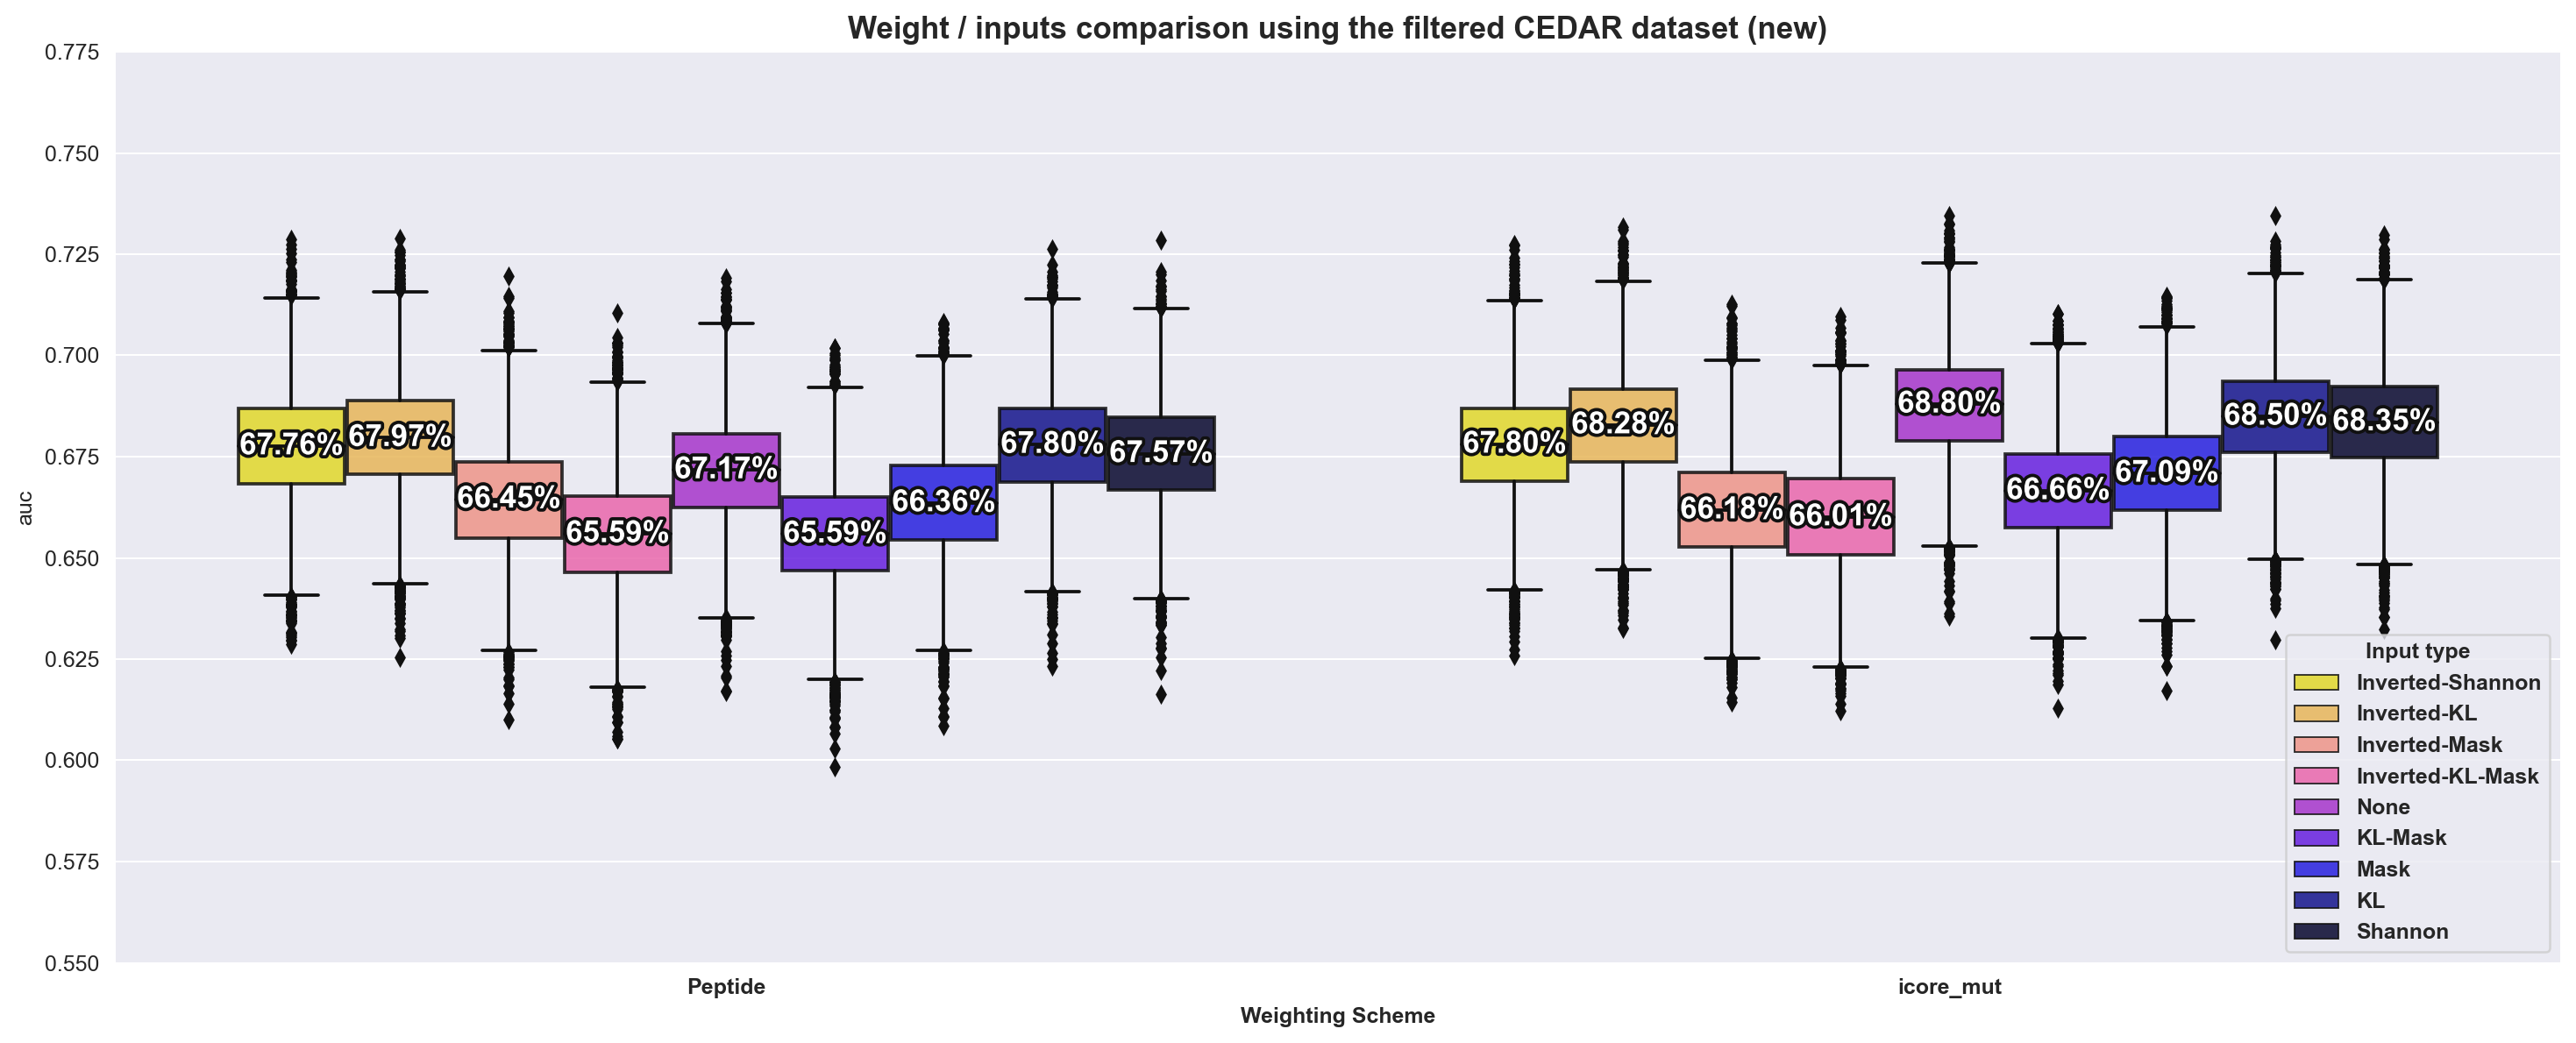

In [43]:
order = ['Inverted-Shannon', 'Inverted-KL', 'Inverted-Mask', 'Inverted-KL-Mask', 
         'None', 'KL-Mask', 'Mask', 'KL', 'Shannon']
ODIR='../output/230613_refiltered_cedar/'
bdf = pd.concat([pd.read_csv(f'{ODIR}{x}') for x in os.listdir(ODIR) if x.endswith('csv')])
f,a = plt.subplots(1,1, figsize=(20,7.5))
sns.boxplot(bdf, y='auc', x='input_type', hue='weight', hue_order=order,
            ax=a, palette={k:v for k,v in zip(order, get_palette('gnuplot2_r', len(order)))})
plt.setp(a.patches, alpha=0.85)
add_median_labels(a, fmt='.2%', fontsize=14)

a.set_title('Weight / inputs comparison using the filtered CEDAR dataset (new)', fontweight='semibold', fontsize=14)

a.set_xticklabels(a.get_xticklabels(), fontweight='semibold')
a.set_xlabel('Weighting Scheme', fontweight='semibold')
a.set_ylim([0.55,0.775])
a.legend(loc='lower right', title='Input type', prop=dict(weight='semibold'), title_fontproperties=dict(weight='semibold'))
f.savefig('../../../writing/230131_cedar_paper_1/supps/2306_weights_NEW.png', dpi=600, bbox_inches='tight')

### comparing to the previous data

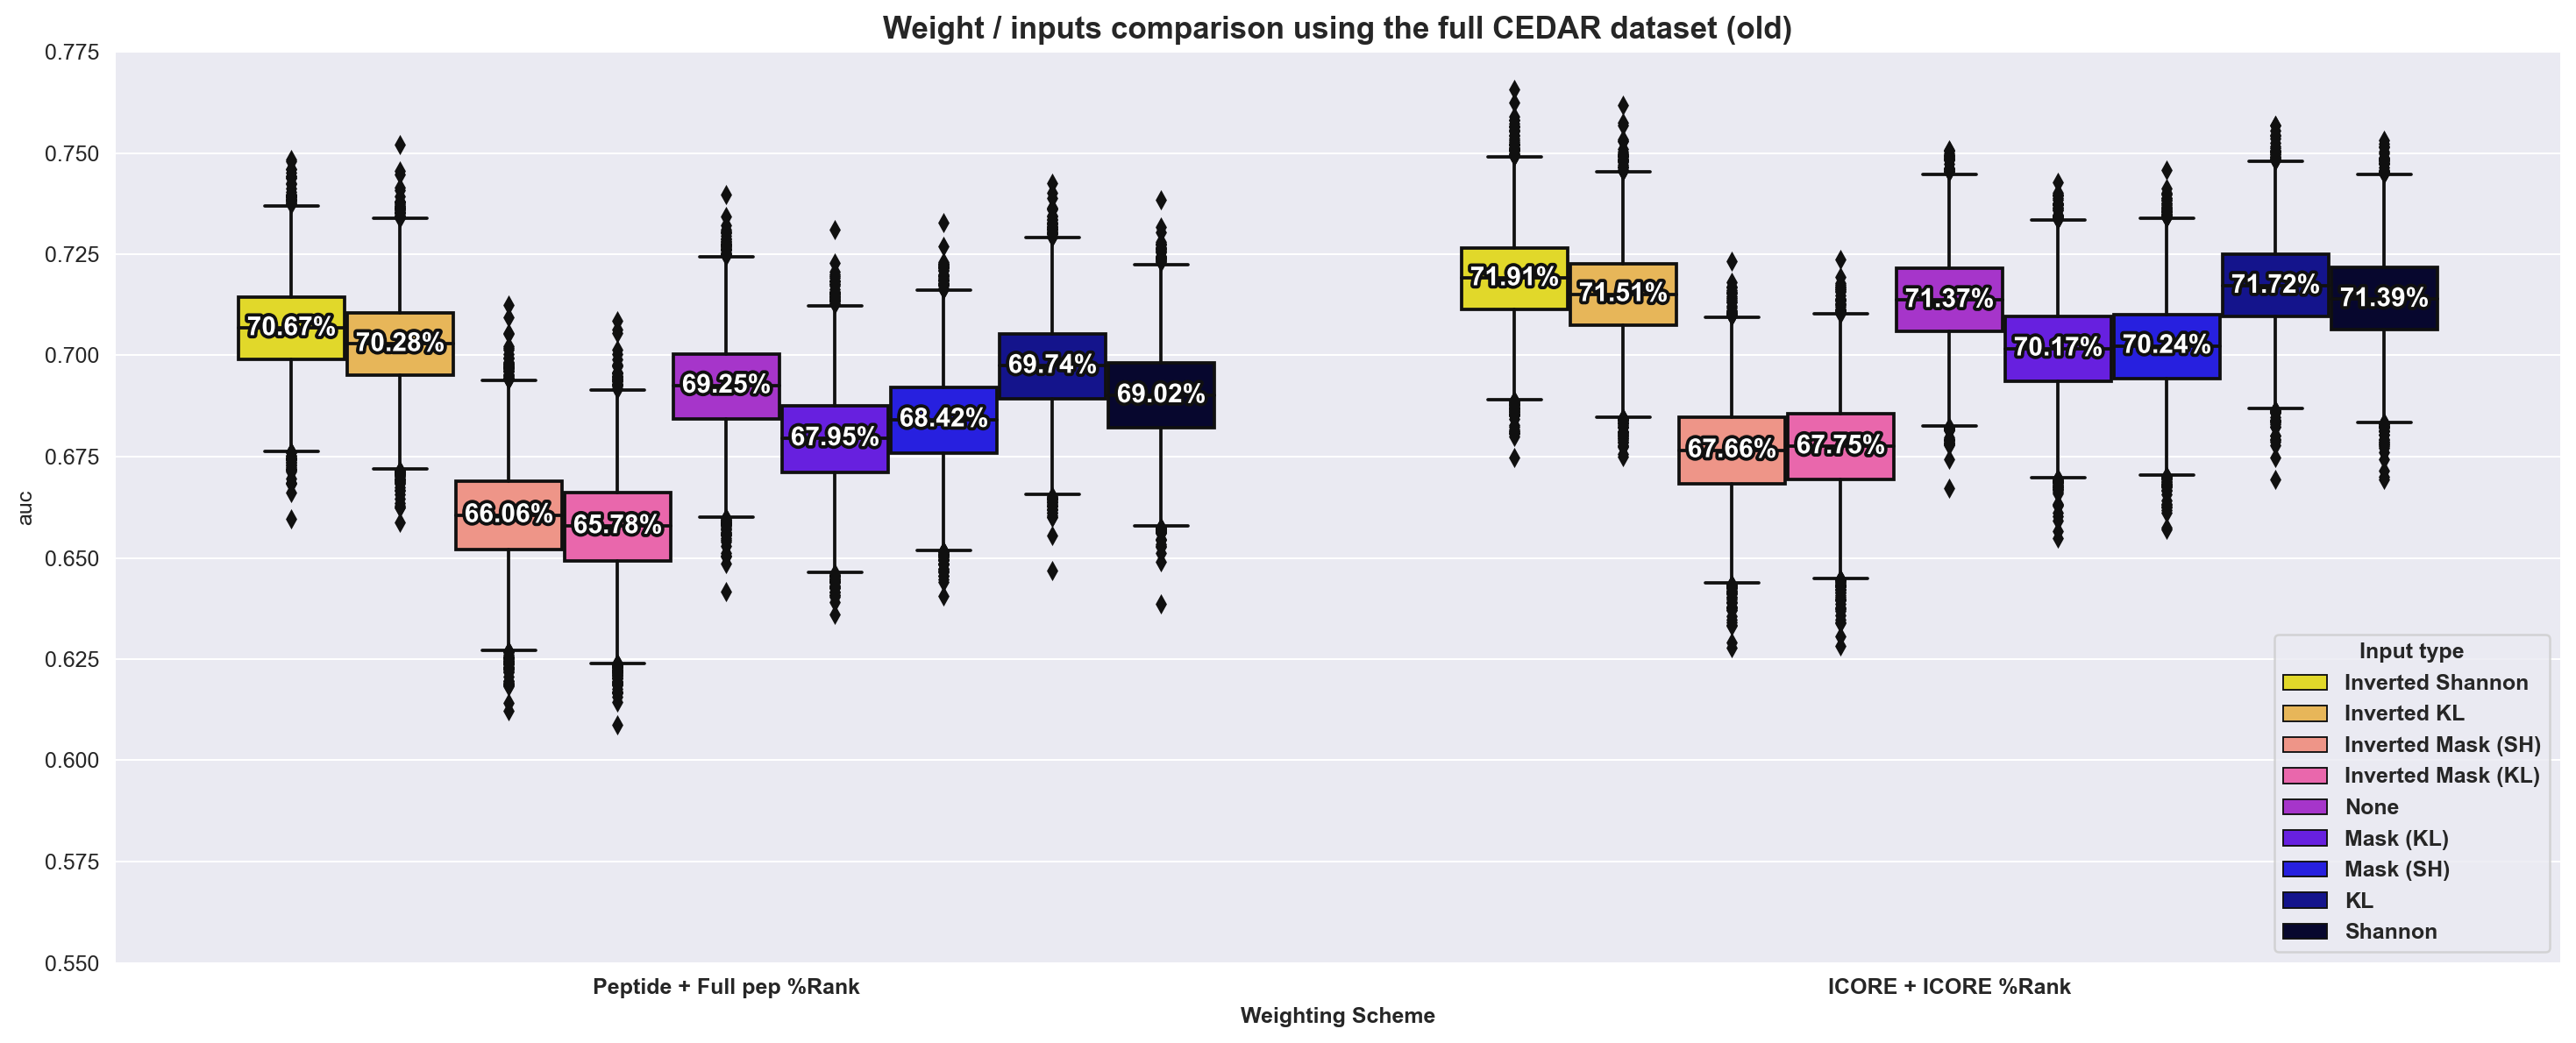

In [44]:
input_df = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/input_df_comparison.csv')
input_df.weight.unique()

xd ={'Inverted-KL':'Inverted (IC)',
     'Inverted-KL-Mask':'Inverted Mask',
     'None':'None',
     'KL-Mask':'Mask', 
     # 'KL':'Normal (1-IC)',
     'Mask' : 'Mask (SH)',
     'Inverted Mask': 'Inverted Mask (SH)'}

def replace_weight(weight, xd ={'Inverted-KL':'Inverted (IC)',
     'Inverted-KL-Mask':'Inverted Mask',
     'None':'None',
     'KL-Mask':'Mask', 
     'KL':'KL',
     'Mask' : 'Mask (SH)',
     # 'Normal (1-IC)' :'KL',
     'Inverted Mask': 'Inverted Mask (SH)'}):
    
    if weight in xd.keys():
        return xd[weight]
    else:
        return weight
    
input_df['weight'] = input_df['weight'].apply(replace_weight, xd=xd)

weight_order_all = ['Inverted Shannon','Inverted KL', 'Inverted Mask (SH)', 'Inverted Mask (KL)',
                    'None',
                    'Mask (KL)', 'Mask (SH)' ,'KL' ,'Shannon']
input_df.weight.unique()
from src.bootstrap import get_pval_wrapper
f,a = plt.subplots(1,1, figsize=(20,7.5))
# ALL

sns.boxplot(data=input_df.query('evalset=="CEDAR" and input_type!="expanded_input"').replace({'Peptide':'Peptide + Full pep %Rank',
                                                             'icore_mut':'ICORE + ICORE %Rank'}),
            x= 'input_type', y='auc', hue = 'weight', hue_order=weight_order_all, 
            palette={k:v for k,v in zip(weight_order_all, get_palette('gnuplot2_r', n_colors=len(weight_order_all)))})
# a.set_title('Inputs comparison, bootstrapped crossvalidation AUCs for CEDAR', fontweight = 'semibold', fontsize=14)
add_median_labels(a, fmt='.2%')

a.set_xticklabels(a.get_xticklabels(), fontweight='semibold')
a.set_xlabel('Weighting Scheme', fontweight='semibold')
a.set_ylim([0.55,0.775])
a.legend(loc='lower right', title='Input type', prop=dict(weight='semibold'), title_fontproperties=dict(weight='semibold'))
a.set_title('Weight / inputs comparison using the full CEDAR dataset (old)', fontweight='semibold', fontsize=14)
f.savefig('../../../writing/230131_cedar_paper_1/supps/2306_weights_OLD.png', dpi=600, bbox_inches='tight')

# Foreignness score split ?

In [6]:
cedar = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
t = 5e-2
len(cedar.query('foreignness_score>=@t')), len(cedar.query('foreignness_score<@t'))

(370, 2618)

In [7]:
from sklearn.metrics import roc_auc_score
t = 1e-1
lower = cedar.query('foreignness_score<@t')
upper = cedar.query('foreignness_score>@t')

print("lower: ", round(roc_auc_score(lower['agg_label'].values, lower['foreignness_score'].values), 5))
print(f"\tnegs = {len(lower.query('agg_label==0'))}, pos = {len(lower.query('agg_label==1'))}, propPos = {len(lower.query('agg_label==1'))/len(lower) : .2%}")
print("upper: ", round(roc_auc_score(upper['agg_label'].values, upper['foreignness_score'].values), 5))
print(f"\tnegs = {len(upper.query('agg_label==0'))}, pos = {len(upper.query('agg_label==1'))}, propPos = {len(upper.query('agg_label==1'))/len(upper) : .2%}")

lower:  0.5123
	negs = 2086, pos = 532, propPos =  20.32%
upper:  0.5877
	negs = 279, pos = 91, propPos =  24.59%


In [35]:
ics_kl = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')
ODIR = '../output/230614_foreignness/'
RDIR = ODIR+'raw/'
BDIR = ODIR+'boot/'
os.makedirs(ODIR, exist_ok=True)
os.makedirs(RDIR, exist_ok=True)
os.makedirs(BDIR, exist_ok=True)

# DEFINING KWARGS
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'hla_col': 'HLA',
                   'add_aaprop': False,
                   'remove_pep': False,
                   'seq_col':'icore_mut',
                   'rank_col':'EL_rank_mut',
                   'mut_col': ['foreignness_score'],
                   'standardize': True}

conditions_list = {'Inverted-Shannon': (True, 'Inverted-Shannon', ics_shannon, False),
                   'None': (False, 'None', None, False),
                   'Mask': (False, 'Mask', ics_shannon, True),
                   'Shannon': (False, 'Shannon', ics_shannon, False),
                   'Inverted-Mask': (True, 'Inverted-Mask', ics_shannon, True),
                   'KL': (False, 'KL', ics_kl, False),
                   'Inverted-KL': (True, 'Inverted-KL', ics_kl, False),
                   'KL-Mask':(False, 'KL-Mask', ics_kl, True),
                   'Inverted-KL-Mask':(True, 'Inverted-KL-Mask', ics_kl, True)}

bdfs=[]
# t = 5e-2
# lower = cedar.query('foreignness_score<@t')
# upper = cedar.query('foreignness_score>@t')

for threshold in tqdm([1e-16, 1e-12, 1e-9, 1e-6, 5e-2], desc='t'):
    bdfs=[]
    lower = cedar.query('foreignness_score<@threshold')
    upper = cedar.query('foreignness_score>@threshold')
    
    for train_dataset, name in zip([lower, cedar, upper], ['lower', 'all', 'upper']):
        invert, ic_name, ics_dict, mask = conditions_list['None']
        # megaloops for encoding-weighting
        encoding_kwargs['encoding'] = 'onehot'
        encoding_kwargs['blosum_matrix'] = None
        # Doing only Inverted Shannon, Mask, None
        encoding_kwargs['invert'] = invert
        encoding_kwargs['mask'] = mask
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
        fn = f'{name}_{threshold:.0e}_foreignness'
        # Training model and getting feature importances
        print('Training')
        trained_models, _, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                        ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs, n_jobs=8)
        _, kcv_preds = evaluate_trained_models_sklearn(train_dataset, trained_models, ics_dict, train_dataset, encoding_kwargs, concatenated=False, only_concat=False, kcv_eval=True, n_jobs=8)
        p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
        kcv_preds.to_csv(f'{RDIR}preds_{fn}.csv', index=False)
        bd = final_bootstrap_wrapper(kcv_preds, fn, name, f'foreignness_{name}', ODIR, n_rounds=10000, n_jobs=8)
        bdfs.append(bd)
    bdfs=pd.concat(bdfs)
    display(bdfs.groupby(['weight']).agg(mean_auc=('auc','mean')))
    bdfs.to_csv(f'{ODIR}bdfs_{threshold:.0e}.csv')

t:   0%|          | 0/5 [00:00<?, ?it/s]

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.721411
foreignness_upper,0.677746


Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.717026
foreignness_upper,0.676648


Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.716719
foreignness_upper,0.672759


Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.715858
foreignness_upper,0.659489


Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.720624
foreignness_upper,0.659932


In [37]:
for f in filter(lambda x: 'boot' not in x and x.endswith('csv'), os.listdir(ODIR)):
    fn = f.replace('bdfs_', '').replace('.csv', '')
    print(fn)
    display(pd.read_csv(ODIR+f).groupby('weight').agg(mean_auc=('auc','mean')))

5e-02


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.720624
foreignness_upper,0.659932


1e-09


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.716719
foreignness_upper,0.672759


1e-16


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.721411
foreignness_upper,0.677746


1e-06


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.715858
foreignness_upper,0.659489


1e-12


,mean_auc
weight,
foreignness_all,0.717733
foreignness_lower,0.717026
foreignness_upper,0.676648


In [38]:
for t in tqdm([1e-16, 1e-12, 1e-9, 1e-6, 1e-4, 0.05], desc='t'):
    
    lower = cedar.query('foreignness_score<@t')
    upper = cedar.query('foreignness_score>=@t')
    print('\n',t,'\n')
    print("lower: ", round(roc_auc_score(lower['agg_label'].values, lower['foreignness_score'].values), 5))
    print(f"\tnegs = {len(lower.query('agg_label==0'))}, pos = {len(lower.query('agg_label==1'))}, propPos = {len(lower.query('agg_label==1'))/len(lower) : .2%}")
    print("upper: ", round(roc_auc_score(upper['agg_label'].values, upper['foreignness_score'].values), 5))
    print(f"\tnegs = {len(upper.query('agg_label==0'))}, pos = {len(upper.query('agg_label==1'))}, propPos = {len(upper.query('agg_label==1'))/len(upper) : .2%}")

t:   0%|          | 0/6 [00:00<?, ?it/s]


 1e-16 

lower:  0.49588
	negs = 1651, pos = 405, propPos =  19.70%
upper:  0.52541
	negs = 714, pos = 218, propPos =  23.39%

 1e-12 

lower:  0.49379
	negs = 1704, pos = 416, propPos =  19.62%
upper:  0.51537
	negs = 661, pos = 207, propPos =  23.85%

 1e-09 

lower:  0.50339
	negs = 1728, pos = 430, propPos =  19.93%
upper:  0.53462
	negs = 637, pos = 193, propPos =  23.25%

 1e-06 

lower:  0.5114
	negs = 1893, pos = 480, propPos =  20.23%
upper:  0.56137
	negs = 472, pos = 143, propPos =  23.25%

 0.0001 

lower:  0.50755
	negs = 1961, pos = 494, propPos =  20.12%
upper:  0.54917
	negs = 404, pos = 129, propPos =  24.20%

 0.05 

lower:  0.5123
	negs = 2086, pos = 532, propPos =  20.32%
upper:  0.5877
	negs = 279, pos = 91, propPos =  24.59%
